In [224]:
!pip install filterpy


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [225]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import json
import Global as gl
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from filterpy.kalman import EnsembleKalmanFilter as EnKF
from filterpy.common import Q_discrete_white_noise

In [226]:
# Set a seed for reproducibility
seed_value = gl.seed_value
np.random.seed(seed_value)

# Macroscopic Solution
$X^0(t,\tau)= \begin{pmatrix}
    x_1 \cos(\tau) - x_2 sin(\tau)\\ \\
    x_1 sin(\tau) + x_2 \cos(\tau)\\ \\
    x_3\\ \\
    x_4\\ \\
\end{pmatrix} $

# Two scale relationship

$X^\epsilon(t,\tau)= \begin{pmatrix}
     R(\tau+v)&0\\
    0 & I_2\\
\end{pmatrix}\times [wY^0(t;x,s)+(1-w)\Gamma] + \epsilon \begin{pmatrix}
    tanh(\sqrt{x_3^2+x_4^2})sin(\tau+v)\\ \\
    tanh(\sqrt{x_3^2+x_4^2})(1-cos(\tau+v))\\ \\
    x_1 sin(\tau)+x_2(cos(\tau)-1)\\ \\
    x1(1-cos(\tau)) +x_2sin(\tau) 
\end{pmatrix}+\dots$
# Macroscopic Dynamics

$\frac{\partial X^0}{\partial t}=BX^0$

$X^0_k=BX^0_{k-1}$

$\begin{pmatrix}
    V_1^{0}\\ \\ V_2^{0}\\ \\ X_1^{0}\\ \\X_2^{0}
\end{pmatrix}_{k}  = \begin{pmatrix}
0 & -1-\epsilon cos(10t) & 0 & 0\\
1+\epsilon cos(10t) & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
\end{pmatrix}
\begin{pmatrix}
    V_1^{0}\\ \\ V_2^{0}\\ \\ X_1^{0}\\ \\X_2^{0}
\end{pmatrix}_{k-1} \\ \\
$

$Y^0_k = Y^0_{k-1}$

# Assimilation parameters
$\begin{cases}
H(x) = x\\
M(x) = x\\
R = 0.01\\
Q = I_3\\
P=0.1I_4\\
N=40
\end{cases}$


## Plotting

In [227]:
def showfunction(df,x1,x2,title):
    plt.plot(df['X'], df['Ye'], label='Xɛ',color='red')
    plt.plot(df['X'], df['Y0'], label='X0')
    # Set axis labels and a title
    plt.title(title)
    # Set axis labels and a title
    plt.xlabel('Time (seconds)')
    plt.legend()
    plt.xlim(x1, x2)

    # Show the plot
    plt.show()

# EnKF

## Intialization

In [228]:
eps=gl.eps
h=gl.h
step=gl.step
x1,x2,x3,x4=gl.x_0
correctors=[]
#In minutes
macrostep=gl.macrostep
#In seconds
microstep=gl.microstep 

def hx(x):
    return np.array([x])

def fx(x,dt):
    return x

x = np.array(gl.x_0)
P = np.eye(4) * 0.1
enf = EnKF(x=x, P=P, dim_z=4, dt=1., N=40, hx=hx, fx=fx)

#enf.R *= np.eye(4)*0.03
#enf.Q = Q_discrete_white_noise(4, step,0.03)
enf.R *= np.eye(4)*0.01
enf.Q[3][3]=0.1
#enf.Q[3][3] = 0.4
print(enf.Q)

[[1.  0.  0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  0.  0.1]]


## Operators

In [229]:
def f(x3,x4):
    return float(np.tanh(np.sqrt(x3**2+x4**2)))

In [230]:
#microscopic operator
#tau = ((1+k)*1800)/eps
def Oe(Y_0,A,v,w,k):
    tau = k/eps
    X_0 = np.array([[np.cos(tau+v),-np.sin(tau+v), 0 ,0],
                   [np.sin(tau+v),np.cos(tau+v), 0 ,0],
                   [0,0, 1 ,0],
                   [0,0, 0 ,1]]) 
    
    
    result =X_0@(w*Y_0+(1-w)*A) +\
          eps * f(x3,x4)*np.array([np.sin(tau+v),
                        f(x3,x4)*(1 - np.cos(tau+v)),
                        x1 * np.sin(tau) + x2 * (np.cos(tau) - 1),
                        x1 * (1 - np.cos(tau)) + x2 * np.sin(tau)]) 
    """+\
            (eps**2)*np.array([
                0,
                0,
                1-np.cos(tau),
                tau -np.sin(tau)
            ])"""
    
    return result
#return np.transpose(np.array([Oe(X,A,w,k+step*i) for i in range(int(microstep/step))]))
#helper function to get estimated microscopic values between 30min-30min+10s

def Xe_Forecast(X,A,v,w,k,microstep):
    return np.transpose(np.array([Oe(X,A,v,w,k+step*i) for i in range(int(microstep/step))]))

## plotting

In [231]:
_default_size = (9, 4)
def plot_measurements(xs, ys=None, dt=None, color='k', lw=1, label='Measurements',
                      lines=False, **kwargs):
    
    if ys is None and dt is not None:
        ys = xs
        xs = np.arange(0, len(ys)*dt, dt)

    plt.autoscale(tight=False)
    if lines:
        if ys is not None:
            return plt.plot(xs, ys, color=color, lw=lw, ls='--', label=label, **kwargs)
        else:
            return plt.plot(xs, color=color, lw=lw, ls='--', label=label, **kwargs)
    else:
        if ys is not None:
            return plt.scatter(xs, ys, edgecolor=color, facecolor='none',
                        lw=2, label=label, **kwargs),
        else:
            return plt.scatter(range(len(xs)), xs, edgecolor=color, facecolor='none',
                        lw=2, label=label, **kwargs),

In [232]:
def plotError(labl,SSE1,SSE2,SSE3,SSE4,title):
    # Generate x values from 0 to 30
    x = np.linspace(0, len(SSE1), len(SSE1))  # Adjust the third parameter to control the number of points

    # Plot the data
    plt.plot(x, SSE1, label=labl+'1')
    plt.plot(x, SSE2, label=labl+'2')
    plt.plot(x, SSE3, label=labl+'3')
    plt.plot(x, SSE4, label=labl+'4')

    # Add labels and title
    plt.xlabel('time (30min)')
    plt.ylabel('SSE')
    plt.title(title)

    # Add a legend
    plt.legend()
    plt.savefig('Plots/'+title+'.png')
    # Show the plot
    plt.show()

In [233]:
def plotAssimilated(x0,xf,n,xlab,title,y1,y1lab,y2,y2lab):
    x = np.linspace(x0, xf, n)  # Adjust the third parameter to control the number of points

    # Plot the data
    plt.plot(x, y1, label=y1lab)
    plt.plot(x, y2, label=y2lab)

    # Add labels and title
    plt.xlabel(xlab)
    plt.ylabel('values')
    plt.title(title)

    # Add a legend
    plt.legend()
    plt.savefig('Plots/'+title+'.png')
    # Show the plot
    plt.show()

In [234]:
def plotAssimilated1(x0,xf,n,xlab,title,y1,y1lab,y2,y2lab):
    x = np.linspace(x0, xf, n)  # Adjust the third parameter to control the number of points

    # Plot the data
    plt.plot(x, y1, label=y1lab)
    plt.plot(x, y2[0], label=y2lab)

    # Add labels and title
    plt.xlabel(xlab)
    plt.ylabel('values')
    plt.title(title)

    # Add a legend
    plt.legend()
    plt.savefig('Plots/'+title+'.png')
    # Show the plot
    plt.show()

## Measurements

In [235]:
file_path1 = 'GenData/True/Cut/'+gl.model_name+'.json'  # Replace 'your_file.json' with the actual file path

with open(file_path1, 'r') as file1:
    data1 = json.load(file1)


V01True = np.array([x[1] for x in data1])
V02True = np.array([x[3] for x in data1])
X01True = np.array([x[5] for x in data1])
X02True = np.array([x[7] for x in data1])



file_path2 = 'GenData/Noised/Cut/'+gl.model_name+'.json'  # Replace 'your_file.json' with the actual file path


with open(file_path2, 'r') as file2:
    data2 = json.load(file2)


V01 = np.array([x[1] for x in data2]) #[V01(1800),V01(3600),....]
Ve1 = np.array([x[2] for x in data2]) #[[Ve1(1800),Ve1(1800.01),...,Ve1(1810)],[Ve1(3600),Ve1(3600.01),...,Ve1(3610)]]
V02 = np.array([x[3] for x in data2])
Ve2 = np.array([x[4] for x in data2])
X01 = np.array([x[5] for x in data2])
Xe1 = np.array([x[6] for x in data2])
X02 = np.array([x[7] for x in data2])
Xe2 = np.array([x[8] for x in data2])

## Assimilation

In [236]:
def MacError(true,estimated):
    result = np.square(true- estimated)
    return result

In [237]:
def MicError(true,estimated):
    result = np.square(true- estimated)/len(true)
    result = [np.sum(result[i]) for i in range(len(result))]
    return result

In [238]:
def err(error):
    return np.sum(np.array(error))

In [239]:
def assimilate(Y0,Ye,Ytrue0):
    results = []
    ps = []
    zs = []
    for t in range (0,len(Y0)):
        # create measurement = t plus white noise
        z = Y0[t]
        zs.append(z)
        enf.predict()
        enf.update(np.asarray(z))
        # save data
        results.append(enf.x)
        ps.append([(3*(enf.P[i,i]**.5)) for i in range(4)])
    
    results = np.asarray(results)
    ps = np.asarray(ps)
    
    SSEMacro=[]
    SSEMicro=[]
    for k in range(0,len(Y0)):
    #microscopic measurements at k
        tt = (gl.macrostep*60)*(k+1)
        micro_measurements = np.array([i for i in Ye[k]])
        micro_measurements = micro_measurements[:int(microstep/step)]
        #SSEMacro.append([np.sqrt(np.square((Ytrue0[k][i] - results[k][i])/Ytrue0[k][i])) for i in range(4)])
        SSEMacro.append(MacError(Ytrue0[k], results[k]))
        #SSEMicro.append([np.sqrt(np.sum(np.square((micro_measurements[i] - Xe_Forecast(results[k],0,1,tt,microstep)[i])/micro_measurements[i])))for i in range(4)])
        
        SSEMicro.append(MicError(micro_measurements , Xe_Forecast(results[k],0,0,1,tt,microstep)))
    #print("MSEMacro ",np.mean(np.array(SSEMacro)),"MSEMicro ",np.mean(np.array(SSEMicro)))
    return [np.transpose(SSEMacro),np.transpose(SSEMicro),np.transpose(Ytrue0),np.transpose(results),micro_measurements,Xe_Forecast(results[k],0,0,1,k,microstep)]
    

In [240]:
def assimilate_minimize(Y0,Ye,Ytrue0):
    
    results = []
    ps = []
    zs = []
    
    initial_params =np.array([0.5,0.5,0.5,0.5,0]) #Ye = Oe(wYa+(1-w)A) with w=0.5
    optimal_params=np.zeros(5)

    for t in range (0,len(Y0)):
        # create measurement = t plus white noise
        z = Y0[t]
        micro_measurements = np.array([i for i in Ye[t]])
        micro_measurements = micro_measurements[:int(microstep/step)]
        zs.append(z)
        
        #Assimilation
        enf.predict()
        enf.update(np.asarray(z))

        #Minimization
        opt1=minimize(lambda params: err(MicError(micro_measurements , Xe_Forecast(enf.x,params[:-1],params[-1],1/2,t,microstep))),initial_params) 

        
        optimal_A=np.array([opt1.x[:-1]])
        optimal_v=opt1.x[-1]
        print("t ",t," A ",optimal_A, " v ",optimal_v)
        correctors.append([optimal_A,optimal_v])
        # save data
        enf.x = 0.5*enf.x +0.5*optimal_A
        results.append(enf.x)
        ps.append([(3*(enf.P[i,i]**.5)) for i in range(4)])

    results = np.asarray(results)
    ps = np.asarray(ps)
    #true=np.array([Ytrue0(i*30*60) for i in range(1,31) ])
    true=np.array(Ytrue0)

    SSEMacro=[]
    SSEMicro=[]
    
    for k in range(0,len(Y0)):
        tt = (gl.macrostep*60)*(k+1)
    #microscopic measurements at k   
        micro_measurements = np.array([i for i in Ye[k]]) 
        micro_measurements = micro_measurements[:int(microstep/step)]
        SSEMacro.append(MacError(Ytrue0[k], results[k]))
        #SSEMacro.append([np.sqrt(np.sum(np.square((true[k][i] - results[k][i])/true[k][i]))) for i in range(4)])
        #SSEMicro.append([np.sqrt(np.sum(np.square((micro_measurements[i] - Xe_Forecast(results[k],0,1,tt,microstep)[i])/micro_measurements[i])))for i in range(4)])
        y_0=results[k].T
        SSEMicro.append(MicError(micro_measurements , Xe_Forecast(y_0,0,correctors[k][1],1,tt,microstep)))
    return [np.transpose(SSEMacro),np.transpose(SSEMicro),np.transpose(true),np.transpose(results),micro_measurements,Xe_Forecast(y_0,0,correctors[k][1],1,tt,microstep)]
    

In [241]:
def CalcError(L,truth,estimated):
    return L(truth,estimated).sum()

# Process

In [242]:
Y0=np.array([[V01[x],V02[x],X01[x],X02[x]] for x in range(len(V01))])
Ye=np.array([[Ve1[x],Ve2[x],Xe1[x],Xe2[x]] for x in range(len(Ve1))])
Y0True=np.array([[V01True[x],V02True[x],X01True[x],X02True[x]] for x in range(len(V01True))])
print(Ye.shape,Y0.shape,Y0True.shape)

(20, 4, 1000) (20, 4) (20, 4)


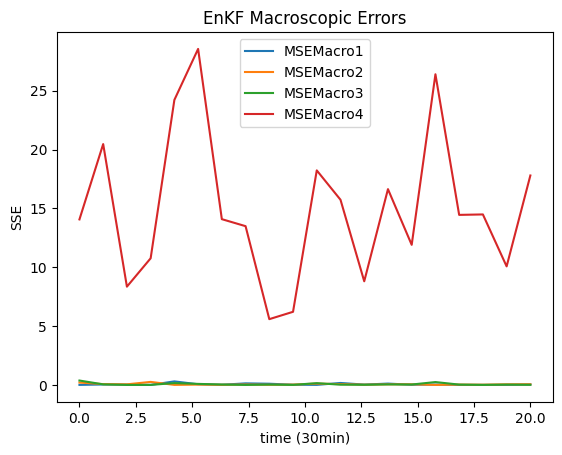

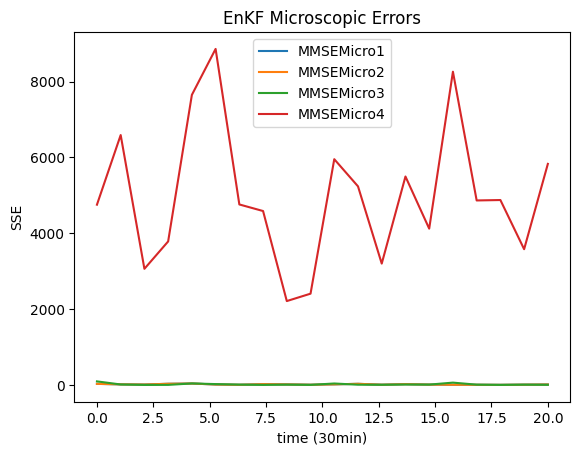

In [243]:
SSEMacro,SSEMicro,trueMacro,assimilatedMacro,lastTrueMicro,lastAssimilatedMicro=assimilate(Y0,Ye,Y0True)
plotError("MSEMacro",SSEMacro[0],SSEMacro[1],SSEMacro[2],SSEMacro[3],"EnKF Macroscopic Errors")
plotError("MMSEMicro",SSEMicro[0],SSEMicro[1],SSEMicro[2],SSEMicro[3],"EnKF Microscopic Errors")

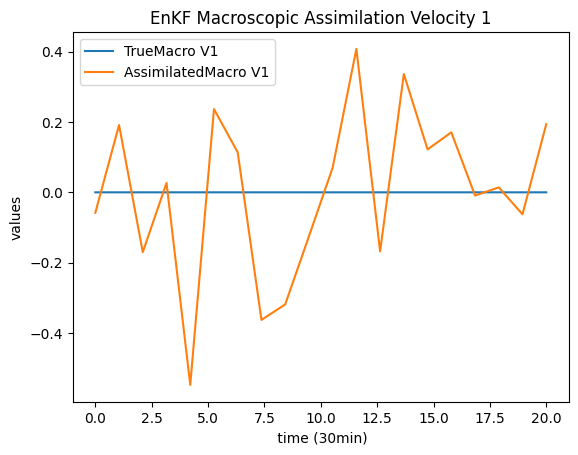

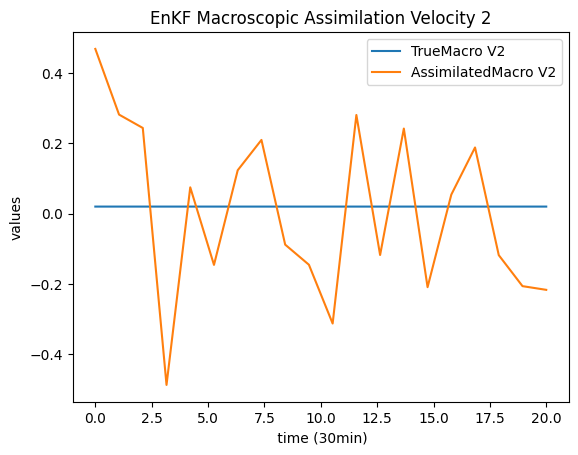

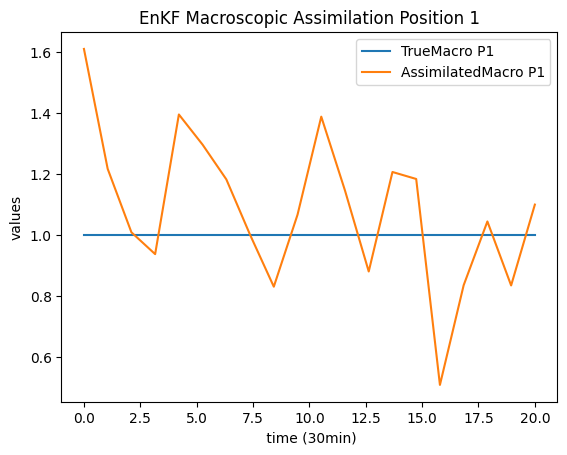

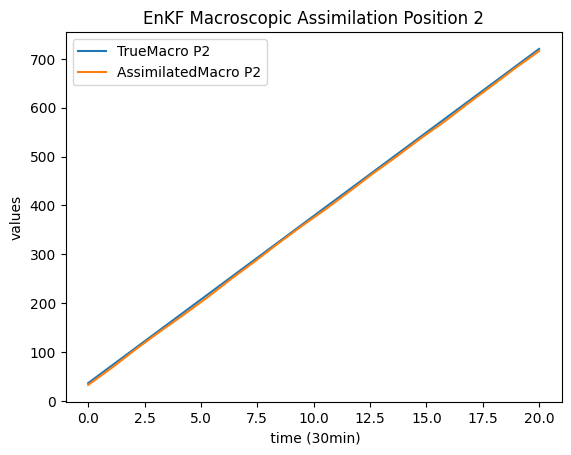

In [244]:
plotAssimilated(0,20,20," time (30min)" , 'EnKF Macroscopic Assimilation Velocity 1',trueMacro[0],'TrueMacro V1',assimilatedMacro[0],"AssimilatedMacro V1")
plotAssimilated(0,20,20," time (30min)" , 'EnKF Macroscopic Assimilation Velocity 2',trueMacro[1],'TrueMacro V2',assimilatedMacro[1],"AssimilatedMacro V2")
plotAssimilated(0,20,20," time (30min)" , 'EnKF Macroscopic Assimilation Position 1',trueMacro[2],'TrueMacro P1',assimilatedMacro[2],"AssimilatedMacro P1")
plotAssimilated(0,20,20," time (30min)" , 'EnKF Macroscopic Assimilation Position 2',trueMacro[3],'TrueMacro P2',assimilatedMacro[3],"AssimilatedMacro P2")

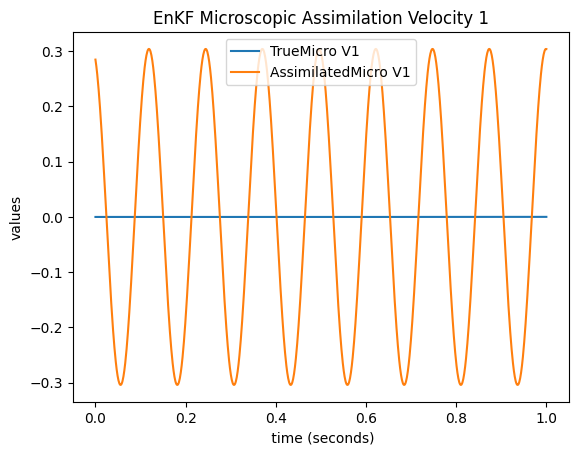

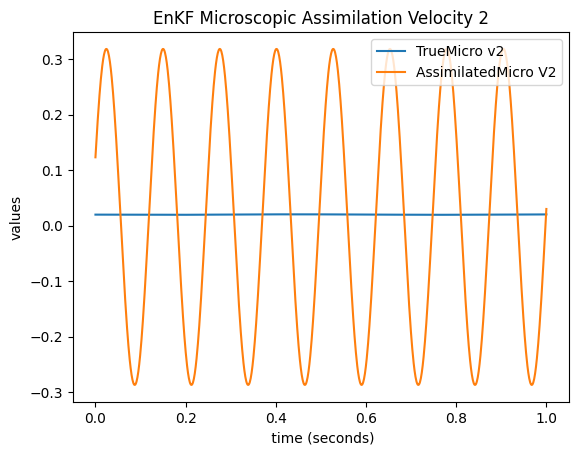

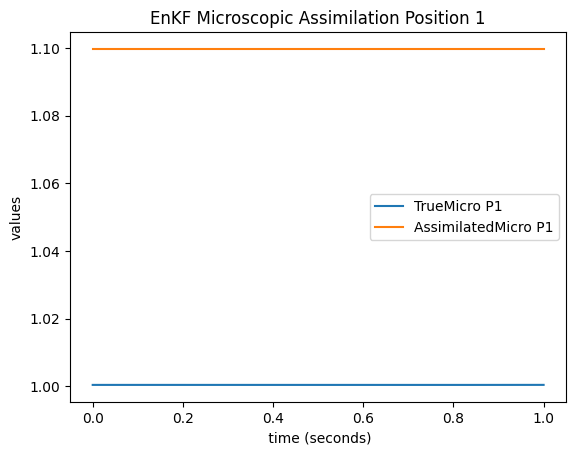

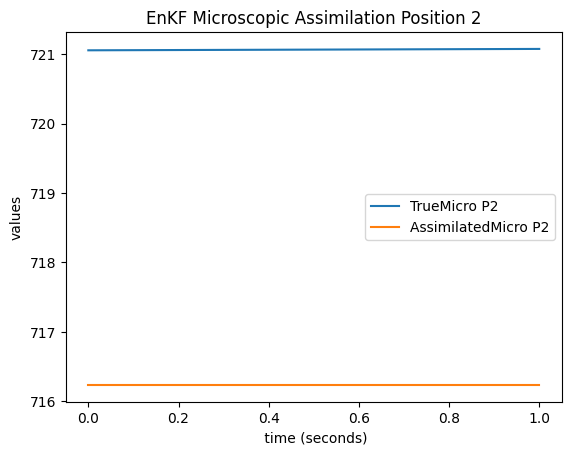

In [245]:
plotAssimilated(0,microstep,int(microstep/step)," time (seconds)" , 'EnKF Microscopic Assimilation Velocity 1',lastTrueMicro[0],'TrueMicro V1',lastAssimilatedMicro[0],"AssimilatedMicro V1")
plotAssimilated(0,microstep,int(microstep/step)," time (seconds)" , 'EnKF Microscopic Assimilation Velocity 2',lastTrueMicro[1],'TrueMicro v2',lastAssimilatedMicro[1],"AssimilatedMicro V2")
plotAssimilated(0,microstep,int(microstep/step)," time (seconds)" , 'EnKF Microscopic Assimilation Position 1',lastTrueMicro[2],'TrueMicro P1',lastAssimilatedMicro[2],"AssimilatedMicro P1")
plotAssimilated(0,microstep,int(microstep/step)," time (seconds)" , 'EnKF Microscopic Assimilation Position 2',lastTrueMicro[3],'TrueMicro P2',lastAssimilatedMicro[3],"AssimilatedMicro P2")

In [246]:
Results_BM = [[np.mean(SSEMacro[0]),np.mean(SSEMicro[0])],[np.mean(SSEMacro[1]),np.mean(SSEMicro[1])],[np.mean(SSEMacro[2]),np.mean(SSEMicro[2])],[np.mean(SSEMacro[3]),np.mean(SSEMicro[3])]]

EnKFMacro1=assimilatedMacro[0]
EnKFMacro2=assimilatedMacro[1]
EnKFMacro3=assimilatedMacro[2]
EnKFMacro4=assimilatedMacro[3]

t  0  A  [[  3.30909912  -3.1868714    6.5487833  -21.62827744]]  v  3.2860199525599
t  1  A  [[-1.82853840e-03 -1.11141056e-01  1.02736533e+00  7.11706938e+01]]  v  -2.1136507207553525
t  2  A  [[ 5.67864216e-02 -1.17963477e-01  1.20053936e+00  1.11965527e+02]]  v  -2.404384398893026
t  3  A  [[ -0.19981528  -0.22269238   1.0708894  149.05886123]]  v  0.08144158042620812
t  4  A  [[-2.63549238e-01  1.01641245e-01  1.47172736e+00  1.84492844e+02]]  v  -2.5033184333412457
t  5  A  [[1.60702762e-01 1.58668637e-01 9.03557815e-01 2.23970329e+02]]  v  0.016007821458076745
t  6  A  [[-1.26817397e-01 -2.61736188e-01  8.49479877e-01  2.57844623e+02]]  v  0.018594027486095843
t  7  A  [[ 4.60814692e-02 -2.93777683e-01  1.11207422e+00  2.92541590e+02]]  v  0.06979559834608083
t  8  A  [[-1.74343304e-01  1.53550774e-02  1.47791711e+00  3.29993249e+02]]  v  0.06415781921923848
t  9  A  [[-2.90550410e-01  1.03780095e-01  9.95581137e-01  3.64627963e+02]]  v  -1.173857061840297
t  10  A  [[-1.2065251

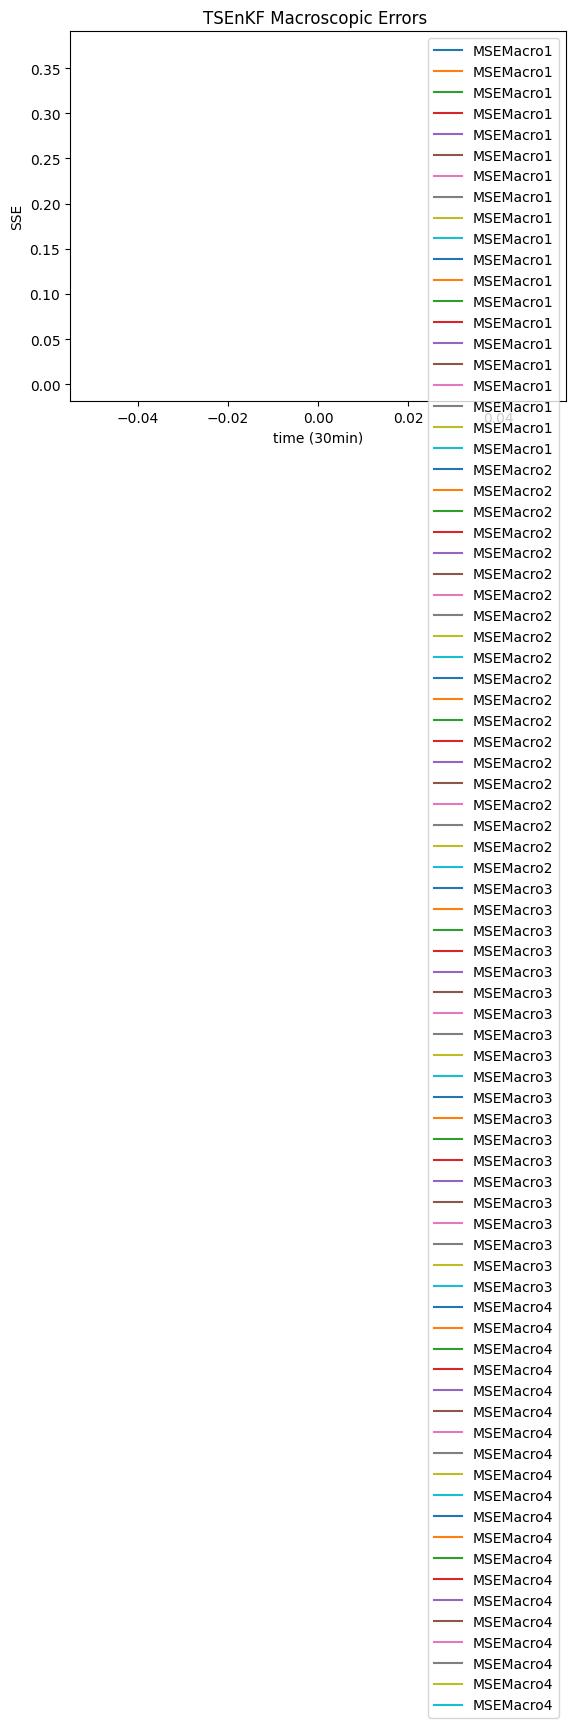

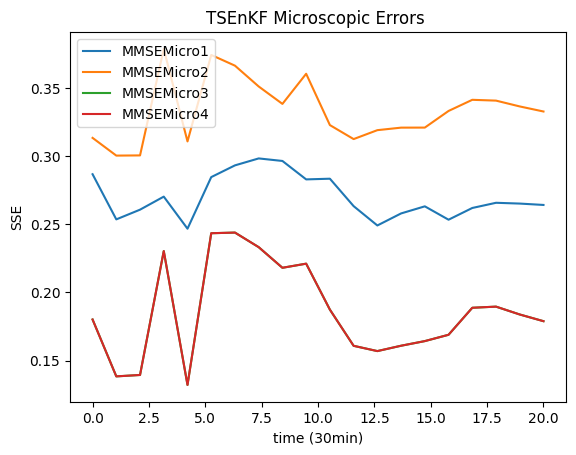

In [ ]:
SSEMacro,SSEMicro,trueMacro,assimilatedMacro,lastTrueMicro,lastAssimilatedMicro=assimilate_minimize(Y0,Ye,Y0True)
plotError("MSEMacro",SSEMacro[0].T,SSEMacro[1].T,SSEMacro[2].T,SSEMacro[3].T,"TSEnKF Macroscopic Errors ")
plotError("MMSEMicro",SSEMicro[0].T,SSEMicro[1].T,SSEMicro[2].T,SSEMicro[3].T,"TSEnKF Microscopic Errors ")

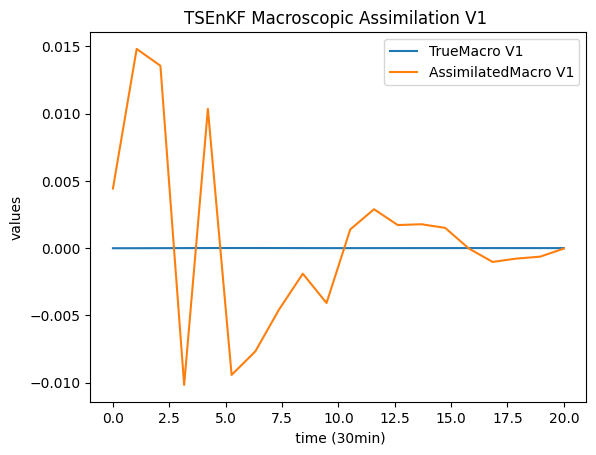

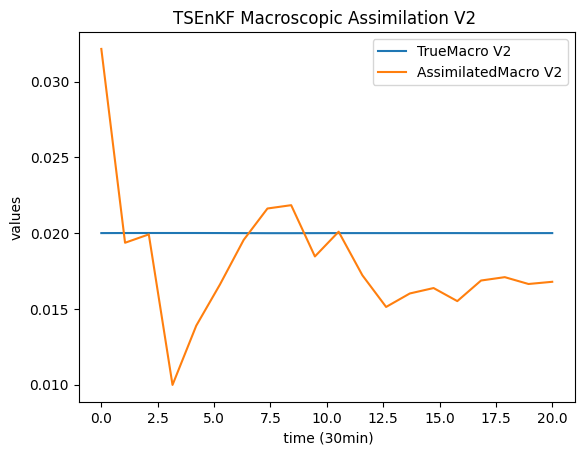

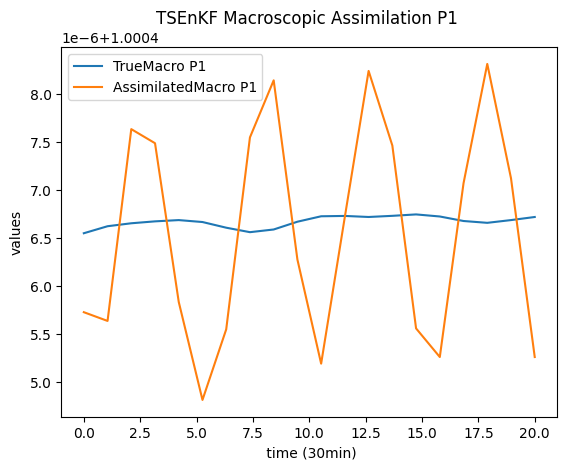

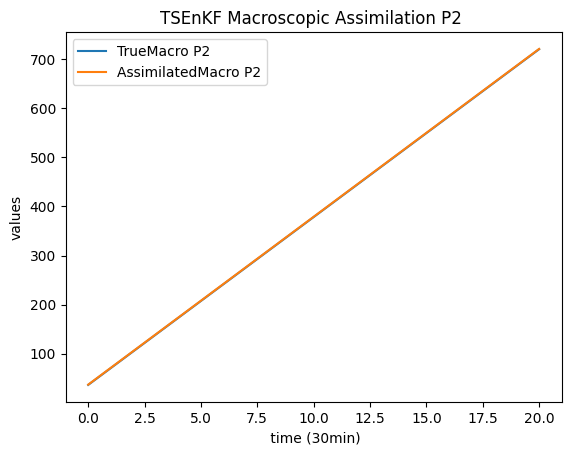

In [248]:
plotAssimilated1(0,20,20," time (30min)" , 'TSEnKF Macroscopic Assimilation V1 ',trueMacro[0],'TrueMacro V1',assimilatedMacro[0],"AssimilatedMacro V1")
plotAssimilated1(0,20,20," time (30min)" , 'TSEnKF Macroscopic Assimilation V2 ',trueMacro[1],'TrueMacro V2',assimilatedMacro[1],"AssimilatedMacro V2")
plotAssimilated1(0,20,20," time (30min)" , 'TSEnKF Macroscopic Assimilation P1 ',trueMacro[2],'TrueMacro P1',assimilatedMacro[2],"AssimilatedMacro P1")
plotAssimilated1(0,20,20," time (30min)" , 'TSEnKF Macroscopic Assimilation P2 ',trueMacro[3],'TrueMacro P2',assimilatedMacro[3],"AssimilatedMacro P2")

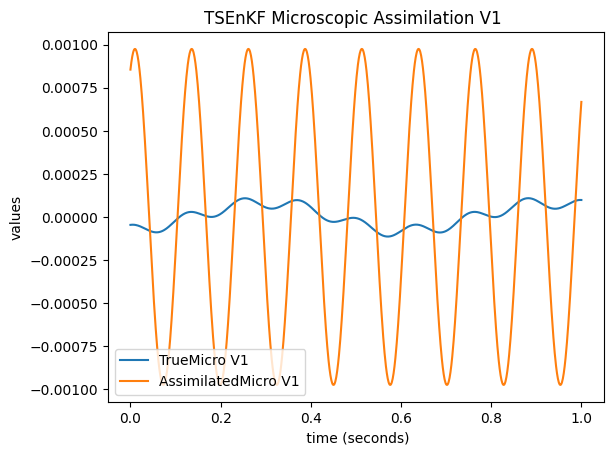

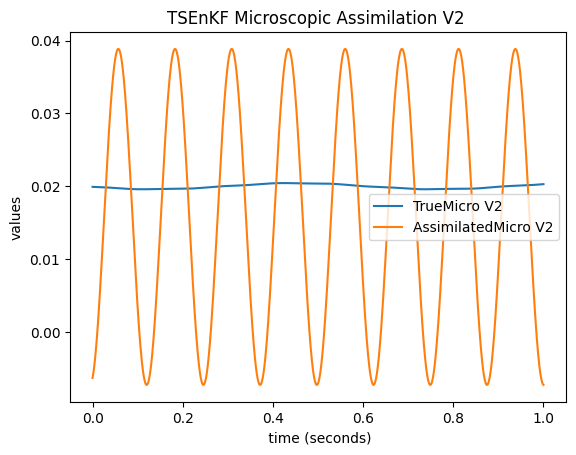

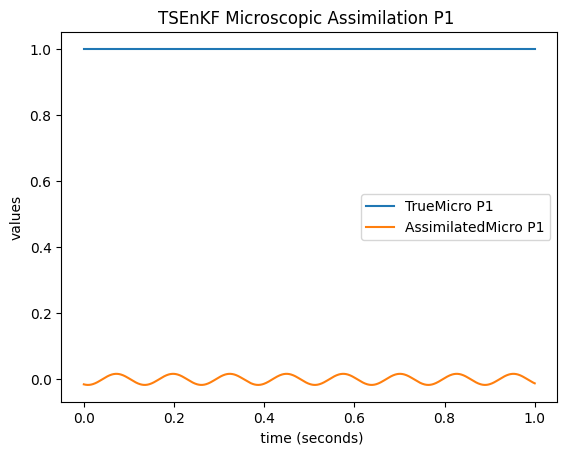

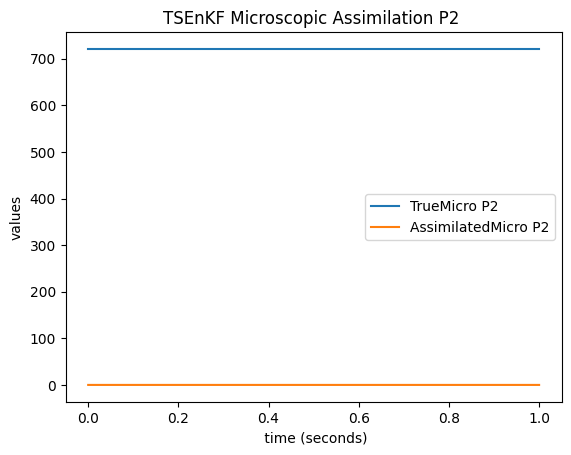

In [249]:


plotAssimilated1(0,microstep,int(microstep/step)," time (seconds)" , 'TSEnKF Microscopic Assimilation V1 ',lastTrueMicro[0],'TrueMicro V1',lastAssimilatedMicro[0],"AssimilatedMicro V1")
plotAssimilated1(0,microstep,int(microstep/step)," time (seconds)" , 'TSEnKF Microscopic Assimilation V2 ',lastTrueMicro[1],'TrueMicro V2',lastAssimilatedMicro[1],"AssimilatedMicro V2")
plotAssimilated1(0,microstep,int(microstep/step)," time (seconds)" , 'TSEnKF Microscopic Assimilation P1 ',lastTrueMicro[2],'TrueMicro P1',lastAssimilatedMicro[2],"AssimilatedMicro P1")
plotAssimilated1(0,microstep,int(microstep/step)," time (seconds)" , 'TSEnKF Microscopic Assimilation P2 ',lastTrueMicro[3],'TrueMicro P2',lastAssimilatedMicro[3],"AssimilatedMicro P2")

In [250]:
print("EnKF")
print("MSEMacro1 ",Results_BM[0][0]," MSEMacro2 ",Results_BM[1][0]," MSEMacro3 ",Results_BM[2][0]," MSEMacro4 ",Results_BM[3][0])
print("MMSEMicro1 ",Results_BM[0][1]," MMSEMicro2 ",Results_BM[1][1]," MMSEMicro3 ",Results_BM[2][1]," MMSEMicro4 ",Results_BM[3][1])

print("TSEnKF")
print("MSEMacro1 ",np.mean(SSEMacro[0])," MSEMacro2 ",np.mean(SSEMacro[1])," MSEMacro3 ",np.mean(SSEMacro[2])," MSEMacro4 ",np.mean(SSEMacro[3]))
print("MMSEMicro1 ",np.mean(SSEMicro[0])," MMSEMicro2 ",np.mean(SSEMicro[1])," MMSEMicro3 ",np.mean(SSEMicro[2])," MMSEMicro4 ",np.mean(SSEMicro[3]))

EnKF
MSEMacro1  0.05435995809625734  MSEMacro2  0.05742350252261101  MSEMacro3  0.06529051364303258  MSEMacro4  15.018294764739363
MMSEMicro1  14.017709293310798  MMSEMicro2  14.02567903012358  MMSEMicro3  16.322693150585067  MMSEMicro4  5004.856231749484
TSEnKF
MSEMacro1  4.214600965426838e-05  MSEMacro2  2.1317618575275775e-05  MSEMacro3  1.3023461040421592e-12  MSEMacro4  0.3722302001911138
MMSEMicro1  0.2699790411638133  MMSEMicro2  0.33363506415230915  MMSEMicro3  0.1859895598593718  MMSEMicro4  0.1859895598593718


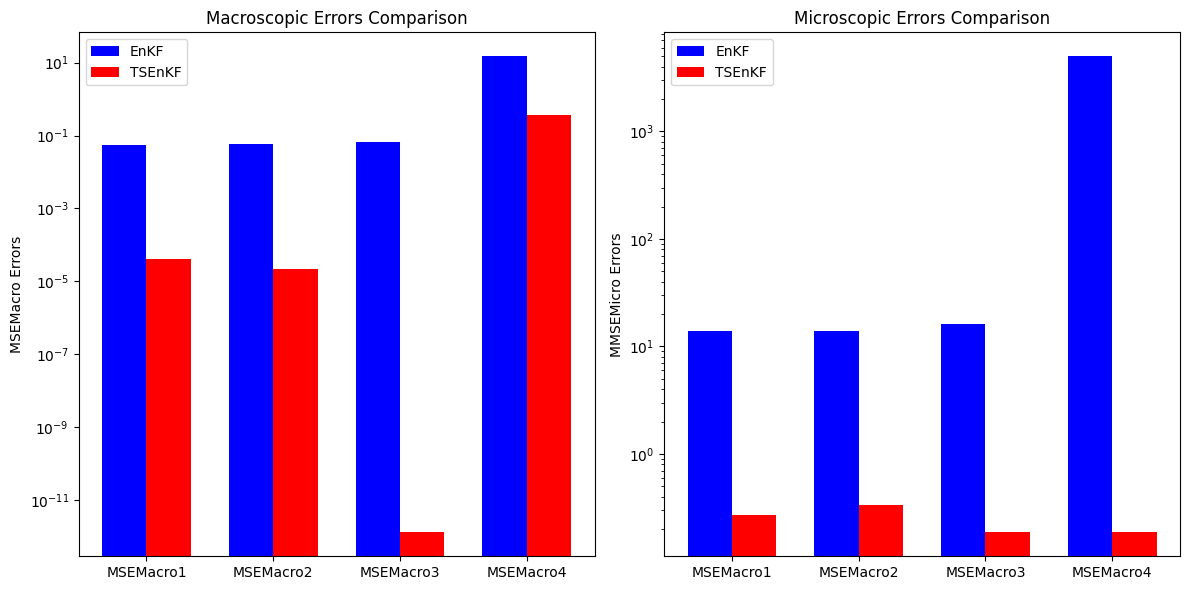

In [258]:
import matplotlib.pyplot as plt
import numpy as np

# EnKF errors
MSEMacro_EnKF = [0.05435995809625734, 0.05742350252261101, 0.06529051364303258, 15.018294764739363]
MMSEMicro_EnKF = [14.017709293310798, 14.02567903012358, 16.322693150585067, 5004.856231749484]

# TSEnKF errors
MSEMacro_TSEnKF = [4.214600965426838e-05, 2.1317618575275775e-05, 1.3023461040421592e-12, 0.3722302001911138]
MMSEMicro_TSEnKF = [0.2699790411638133, 0.33363506415230915, 0.1859895598593718, 0.1859895598593718]

# Indices for the x-axis
labels = ['MSEMacro1', 'MSEMacro2', 'MSEMacro3', 'MSEMacro4']

# Plotting Macroscopic Errors (MSEMacro)
plt.figure(figsize=(12, 6))

# Subplot 1: MSEMacro comparison
plt.subplot(1, 2, 1)
x = np.arange(len(labels))
width = 0.35  # Width of the bars

plt.bar(x - width/2, MSEMacro_EnKF, width, label='EnKF', color='b')
plt.bar(x + width/2, MSEMacro_TSEnKF, width, label='TSEnKF', color='r')

plt.ylabel('MSEMacro Errors')
plt.title('Macroscopic Errors Comparison')
plt.xticks(x, labels)
plt.yscale('log')  # Use logarithmic scale due to the large range of errors
plt.legend()

# Subplot 2: MMSEMicro comparison
plt.subplot(1, 2, 2)
plt.bar(x - width/2, MMSEMicro_EnKF, width, label='EnKF', color='b')
plt.bar(x + width/2, MMSEMicro_TSEnKF, width, label='TSEnKF', color='r')

plt.ylabel('MMSEMicro Errors')
plt.title('Microscopic Errors Comparison')
plt.xticks(x, labels)
plt.yscale('log')  # Use logarithmic scale due to the large range of errors
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [251]:
TSEnKFMacro1=assimilatedMacro[0]
TSEnKFMacro2=assimilatedMacro[1]
TSEnKFMacro3=assimilatedMacro[2]
TSEnKFMacro4=assimilatedMacro[3]

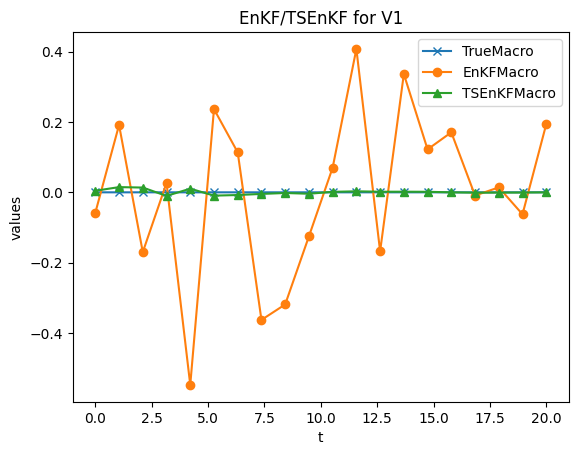

In [252]:
x = np.linspace(0, 20,20)  # Adjust the third parameter to control the number of points

# Plot the data
plt.plot(x, trueMacro[0],marker='x', label="TrueMacro")
plt.plot(x, EnKFMacro1,marker='o', label="EnKFMacro")
plt.plot(x, TSEnKFMacro1[0],marker='^', label="TSEnKFMacro")


# Add labels and title
plt.xlabel("t")
plt.ylabel('values')
plt.title("EnKF/TSEnKF for V1")

# Add a legend
plt.legend()
# Show the plot
plt.show()

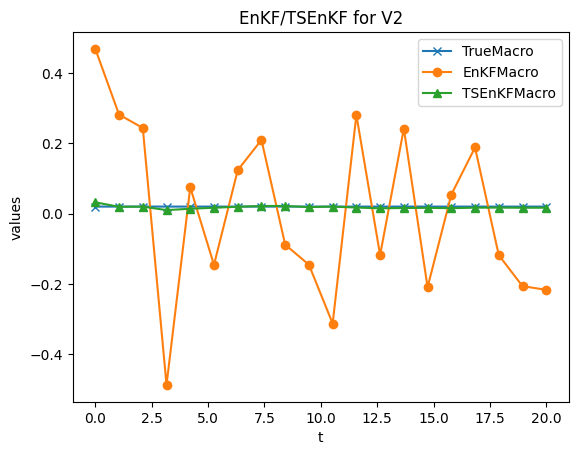

In [253]:
x = np.linspace(0, 20,20)  # Adjust the third parameter to control the number of points

# Plot the data
plt.plot(x, trueMacro[1],marker='x', label="TrueMacro")
plt.plot(x, EnKFMacro2,marker='o', label="EnKFMacro")
plt.plot(x, TSEnKFMacro2[0],marker='^', label="TSEnKFMacro")


# Add labels and title
plt.xlabel("t")
plt.ylabel('values')
plt.title("EnKF/TSEnKF for V2")

# Add a legend
plt.legend()
# Show the plot
plt.show()

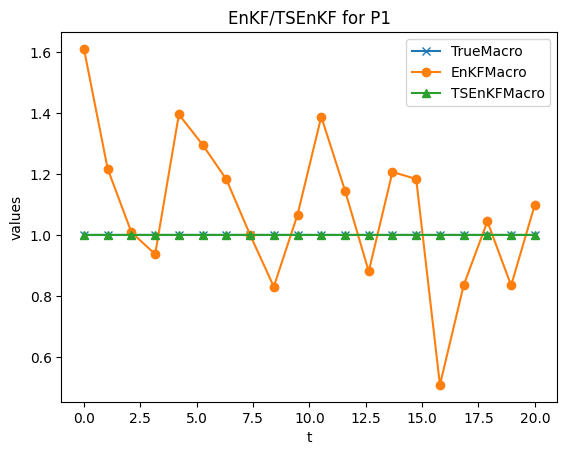

In [254]:
x = np.linspace(0, 20,20)  # Adjust the third parameter to control the number of points

# Plot the data
plt.plot(x, trueMacro[2],marker='x', label="TrueMacro")
plt.plot(x, EnKFMacro3,marker='o', label="EnKFMacro")
plt.plot(x, TSEnKFMacro3[0],marker='^', label="TSEnKFMacro")


# Add labels and title
plt.xlabel("t")
plt.ylabel('values')
plt.title("EnKF/TSEnKF for P1")

# Add a legend
plt.legend()
# Show the plot
plt.show()

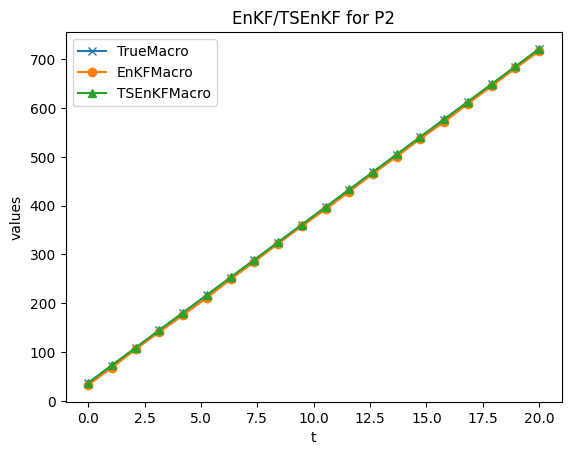

In [255]:
x = np.linspace(0, 20,20)  # Adjust the third parameter to control the number of points

# Plot the data
plt.plot(x, trueMacro[3],marker='x', label="TrueMacro")
plt.plot(x, EnKFMacro4,marker='o', label="EnKFMacro")
plt.plot(x, TSEnKFMacro4[0],marker='^', label="TSEnKFMacro")


# Add labels and title
plt.xlabel("t")
plt.ylabel('values')
plt.title("EnKF/TSEnKF for P2")

# Add a legend
plt.legend()
# Show the plot
plt.show()